#**LIBRARY**

In [1]:
import json
import re
import string
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf

import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nlp_id.lemmatizer import Lemmatizer
from nlp_id.stopword import StopWord
from nlp_id.tokenizer import Tokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from wordcloud import WordCloud

import joblib

c:\Users\taufi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(precision=2, linewidth=80)

In [3]:
# --- BAGIAN NLTK TANPA TRY-EXCEPT ---
# Mengunduh resource NLTK yang dibutuhkan secara langsung
print("Downloading NLTK 'punkt' tokenizer...")
nltk.download('punkt')

print("Downloading NLTK 'stopwords' corpus...")
nltk.download('stopwords')

print("Downloading NLTK 'wordnet' corpus...")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\taufi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taufi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\taufi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#**DATA**

In [4]:
tokenizer_id = Tokenizer()
stopword_id = StopWord()
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

In [5]:
with open('D:/22.11.5169/SEM 6/PROJ DATMIN/huh/vvv/txt/combined_slang_words.txt') as f:
    data_slang = f.read()
formal_indo = json.loads(data_slang)
print("\nKamus normalisasi slang berhasil dimuat.")


Kamus normalisasi slang berhasil dimuat.


In [6]:
def informal_to_formal_indo(text):
    if not formal_indo:
        return text
    # Gunakan split() untuk memisahkan kata dan get() untuk mencari di kamus
    res = " ".join(formal_indo.get(ele, ele) for ele in text.split())
    return res

In [7]:
def my_full_text_preprocessor_optimized(doc):
    # Membersihkan karakter khusus
    doc = re.sub(r'@[A-Za-z0-9]+', '', doc) # Menghapus mention
    doc = re.sub(r'#[A-Za-z0-9]+', '', doc) # Menghapus hashtag
    doc = re.sub(r'RT[\s]', '', doc) # Menghapus RT
    doc = re.sub(r"http\S+", '', doc) # Menghapus URL
    doc = re.sub(r'[0-9]+', '', doc) # Menghapus angka
    doc = re.sub(r'(.)\1{2,}',r'\1\1', doc) # Mengurangi pengulangan karakter lebih dari 2x (contoh: "halooolo" -> "halolo")
    doc = re.sub(r'[\?\.\!]+(?=[\?.\!])', '',doc) # Mengurangi pengulangan tanda baca (contoh: "????" -> "??")
    doc = re.sub(r'[^a-zA-Z ]','', doc) # Hanya menyisakan huruf alfabet dan spasi
    doc = re.sub(r'\b(\w+)( \1\b)+', r'\1', doc) # Menghapus pengulangan kata (contoh: "baik baik" -> "baik")
    doc = doc.replace('\n', ' ') # Mengganti newline dengan spasi
    doc = doc.strip(' ') # Menghapus spasi di awal/akhir

    # Mengubah menjadi huruf kecil
    doc = doc.lower()

    # Text Normalization (kata slang)
    doc = informal_to_formal_indo(doc)

    # Whitespace Removal
    doc = doc.strip()

    # Tokenization
    doc_tokens = tokenizer_id.tokenize(doc)

    # Stopwords Removal
    doc_tokens_no_stopwords = [word for word in doc_tokens if word not in stopword_id.get_stopword()]

    # Stemming (menggunakan Sastrawi) - Pilihan: Stemming Sastrawi atau Lemmatization nlp_id
    doc_stemmed_tokens = [stemmer.stem(word) for word in doc_tokens_no_stopwords]

    # Gabungkan kembali menjadi string
    return " ".join(doc_stemmed_tokens)

In [8]:
df = pd.read_csv("D:/22.11.5169/SEM 6/PROJ DATMIN/huh/vvv/csv/youtube-comments.csv")
df.columns = ["Time", "UserName", "Comment", "LikeCount"]
df.head()

,Time,UserName,Comment,LikeCount
0,2025-05-15T15:04:49Z,@fajarhamdani1134,Sangat betul...,0
1,2025-05-13T21:18:46Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
2,2025-05-13T21:18:23Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
3,2025-05-13T21:12:52Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
4,2025-05-13T21:11:00Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0


#**DATA DESCRIPTION**

In [9]:
print("Ukuran dataset:", df.shape)

Ukuran dataset: (19686, 4)


In [10]:
print("\nInfo kolom:")
df.info()


Info kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19686 entries, 0 to 19685
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       19686 non-null  object
 1   UserName   19684 non-null  object
 2   Comment    19686 non-null  object
 3   LikeCount  19686 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 615.3+ KB


In [11]:
df.describe()
print(df.describe())

          LikeCount
count  19686.000000
mean       3.239155
std      106.122095
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max    10225.000000


In [12]:
print("\nCek Nilai Kosong:")
print(df.isnull().sum())


Cek Nilai Kosong:
Time         0
UserName     2
Comment      0
LikeCount    0
dtype: int64


In [13]:
print("\nJumlah komentar unik:", df['Comment'].nunique())
print("Jumlah komentar duplikat:", df.duplicated('Comment').sum())


Jumlah komentar unik: 19297
Jumlah komentar duplikat: 389


#**CLEANING DATA**

In [14]:
df = df.dropna()
print("\nSetelah menghapus nilai kosong:")
print(df.isnull().sum())


Setelah menghapus nilai kosong:
Time         0
UserName     0
Comment      0
LikeCount    0
dtype: int64


In [15]:
df = df.drop_duplicates(subset="Comment", keep="first")
df.head()

,Time,UserName,Comment,LikeCount
0,2025-05-15T15:04:49Z,@fajarhamdani1134,Sangat betul...,0
1,2025-05-13T21:18:46Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
5,2025-05-13T15:41:27Z,@BadariahAhmad-b7t,Kerja sawit di msia sudah middle upper class bro,0
6,2025-05-13T09:29:59Z,@mibaa7578,Seorang yg begitu bijak.. tahniah org muda.❤,0
7,2025-05-13T06:34:59Z,@RobiRahmathidayat01,Parah 😂,0


In [16]:
# Terapkan pra-pemrosesan yang dioptimalkan
df['processed_comment'] = df['Comment'].apply(my_full_text_preprocessor_optimized)
print("\nKolom 'Comment' setelah pre-processing (processed_comment):")
print(df[['Comment', 'processed_comment']].head())

# Simpan hasil pra-pemrosesan jika diperlukan untuk inspeksi
df.to_csv('Youtube-Processed-Comments.csv', index=False)
print("\nFile CSV pra-pemrosesan berhasil disimpan.")


Kolom 'Comment' setelah pre-processing (processed_comment):
                                             Comment  \
0                                    Sangat betul...   
1  Ternak MULYONO manaaa ngertiiii......biangnya ...   
5   Kerja sawit di msia sudah middle upper class bro   
6       Seorang yg begitu bijak.. tahniah org muda.❤   
7                                            Parah 😂   

                                   processed_comment  
0                                                     
1  ternak mulyono manaa ngertiibiangnya gak jelaa...  
5   kerja sawit msia middle upper class saudara laki  
6                             bijak tahniah org muda  
7                                              parah  

File CSV pra-pemrosesan berhasil disimpan.


#**SENTIMEN ANALISIS BERBASIS LEXICAN**

In [17]:
def loadLexicon(file_path):
    with open(file_path, "r", encoding="utf-8", errors='replace') as f:
        data = f.readlines()
    return [d.strip().lower() for d in data if d.strip()]

In [18]:
positif_words_ta2 = loadLexicon("D:/22.11.5169/SEM 6/PROJ DATMIN/huh/vvv/txt/positif_ta2.txt")
positif_words_keyword = loadLexicon("D:/22.11.5169/SEM 6/PROJ DATMIN/huh/vvv/txt/positive_keyword.txt")
positif_words_add = loadLexicon("D:/22.11.5169/SEM 6/PROJ DATMIN/huh/vvv/txt/positive_add.txt")

In [22]:
# Gabungkan dan pastikan unik
all_positive_words = list(set(positif_words_ta2 + positif_words_keyword + positif_words_add))

all_negative_words = loadLexicon("D:/22.11.5169/SEM 6/PROJ DATMIN/huh/vvv/txt/negatif_ta2.txt")

negasi_words = loadLexicon("D:/22.11.5169/SEM 6/PROJ DATMIN/huh/vvv/txt/negation.txt")
negasi_words_after = loadLexicon("D:/22.11.5169/SEM 6/PROJ DATMIN/huh/vvv/txt/negation_after.txt") # Jika relevan
all_negation_words = list(set(negasi_words + negasi_words_after))

In [23]:
print("\nKamus leksikon bahasa Indonesia (positif, negatif, negasi) berhasil dimuat dan digabungkan.")


Kamus leksikon bahasa Indonesia (positif, negatif, negasi) berhasil dimuat dan digabungkan.


In [24]:
# Buat leksikon sebagai dictionary dengan skor default
sentiment_lexicon = {}
for word in all_positive_words:
    sentiment_lexicon[word] = 1
for word in all_negative_words:
    sentiment_lexicon[word] = -1

In [25]:
# Daftar intensifier dan reducers beserta faktor pengalinya (bisa disesuaikan)
intensifiers = {'sangat': 1.5, 'amat': 1.5, 'sekali': 1.5, 'banget': 1.5, 'paling': 1.5}
reducers = {'agak': 0.5, 'kurang': 0.5, 'sedikit': 0.5}

In [27]:
def prediksiSentiment_lexicon_advanced(kalimat_str, sentiment_lexicon, negasi_list, intensifiers, reducers):
    total_score = 0
    words_in_sentence = kalimat_str.split()
    
    # Track jika kata sebelumnya adalah negasi
    is_prev_word_negation = False
    
    for i, word in enumerate(words_in_sentence):
        current_word_score = 0
        
        # Cek apakah kata saat ini adalah kata negasi
        if word in negasi_list:
            is_prev_word_negation = True
            continue # Lanjutkan ke kata berikutnya, negasi akan diterapkan pada kata sentimen berikutnya
        else:
            is_prev_word_negation = False # Reset flag jika bukan kata negasi

        # Cek apakah kata saat ini adalah intensifier/reducer
        multiplier = 1.0
        if word in intensifiers:
            multiplier = intensifiers[word]
            # Jika intensifier, aplikasikan ke kata sentimen berikutnya jika ada
            if i + 1 < len(words_in_sentence) and words_in_sentence[i+1] in sentiment_lexicon:
                pass # Biarkan multiplier digunakan pada kata berikutnya
            else:
                # Jika intensifier berdiri sendiri atau tidak diikuti kata sentimen, abaikan sebagai multiplier
                multiplier = 1.0
            continue # Langsung ke kata berikutnya karena intensifier sendiri tidak punya sentimen

        elif word in reducers:
            multiplier = reducers[word]
            # Jika reducer, aplikasikan ke kata sentimen berikutnya jika ada
            if i + 1 < len(words_in_sentence) and words_in_sentence[i+1] in sentiment_lexicon:
                pass # Biarkan multiplier digunakan pada kata berikutnya
            else:
                multiplier = 1.0
            continue # Langsung ke kata berikutnya

        # Cek apakah kata adalah sentimen
        if word in sentiment_lexicon:
            score = sentiment_lexicon[word]

            # Terapkan negasi dari kata sebelumnya
            if i > 0 and words_in_sentence[i-1] in negasi_list:
                score *= -1 # Membalikkan sentimen

            # Terapkan intensifier/reducer dari kata sebelumnya
            # Ini asumsi sederhana, bisa lebih kompleks
            if i > 0:
                prev_word = words_in_sentence[i-1]
                if prev_word in intensifiers:
                    score *= intensifiers[prev_word]
                elif prev_word in reducers:
                    score *= reducers[prev_word]
            
            total_score += score

    # Tentukan sentimen berdasarkan total_score
    if total_score > 0.0:
        return 'positif'
    elif total_score < 0.0:
        return 'negatif'
    else:
        return 'netral' # Bisa diubah menjadi range (e.g., -0.1 to 0.1)

In [28]:
# Terapkan model leksikon pada kolom 'processed_comment'
df['label_lexicon'] = df['processed_comment'].apply(
    lambda x: prediksiSentiment_lexicon_advanced(x, sentiment_lexicon, all_negation_words, intensifiers, reducers)
)

In [29]:
print("\nDataset setelah pelabelan sentimen dengan leksikon (Advanced):")
print(df[['Comment', 'processed_comment', 'label_lexicon']].head())


Dataset setelah pelabelan sentimen dengan leksikon (Advanced):
                                             Comment  \
0                                    Sangat betul...   
1  Ternak MULYONO manaaa ngertiiii......biangnya ...   
5   Kerja sawit di msia sudah middle upper class bro   
6       Seorang yg begitu bijak.. tahniah org muda.❤   
7                                            Parah 😂   

                                   processed_comment label_lexicon  
0                                                           netral  
1  ternak mulyono manaa ngertiibiangnya gak jelaa...        netral  
5   kerja sawit msia middle upper class saudara laki       positif  
6                             bijak tahniah org muda       positif  
7                                              parah       negatif  



Distribusi Sentimen setelah pelabelan leksikon:
label_lexicon
netral     7078
positif    6524
negatif    5693
Name: count, dtype: int64


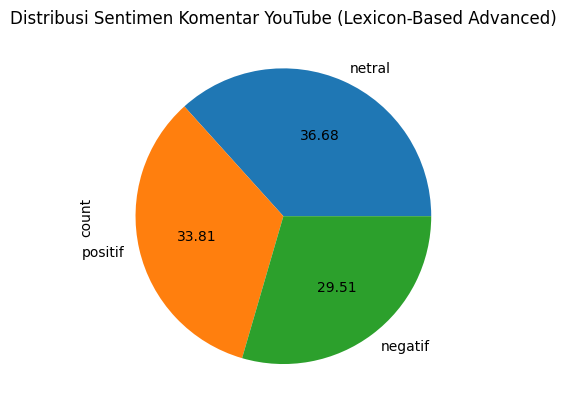

In [30]:
print("\nDistribusi Sentimen setelah pelabelan leksikon:")
print(df['label_lexicon'].value_counts())
df['label_lexicon'].value_counts().plot.pie(autopct='%.2f')
plt.title("Distribusi Sentimen Komentar YouTube (Lexicon-Based Advanced)")
plt.show()

###**Sample Code**

In [ ]:
df['label_lexicon_numeric'] = df['label_lexicon'].map({'negatif': 0, 'positif': 1, 'netral': 2})

In [31]:
df.to_csv('Youtube-Sentimen.csv', index=False)

print("File CSV berhasil disimpan.")

File CSV berhasil disimpan.
